## Installation & Libraries  



# speculative_sampling
@ Itai Shapira

Harvard CS229.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.0 MB/s eta 0:00:00


In [ ]:
# Transformers (huggingface)  provides APIs and tools to easily download and train state-of-the-art pretrained models.
from transformers import GPT2Tokenizer, GPT2LMHeadModel  # Model configuration class

import torch
import time         # measuring speedups

import numpy as np 
import pandas as pd
pd.set_option('precision', 2)

import seaborn as sns

## Import Models

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [ ]:
SMALL_MODEL_ID = "gpt2"
BIG_MODEL_ID = "gpt2-large"

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(SMALL_MODEL_ID) 

small_model = GPT2LMHeadModel.from_pretrained(SMALL_MODEL_ID, pad_token_id = tokenizer.eos_token_id).to(device)
big_model = GPT2LMHeadModel.from_pretrained(BIG_MODEL_ID, pad_token_id = tokenizer.eos_token_id).to(device)

In [ ]:
text_str = "School Of Engineering And Applied"
input_ids = tokenizer.encode(text_str, return_tensors = "pt").to(device)
print(len(input_ids[0]))
output = small_model(input_ids)

5


##Rejection Sampling
below we implement the algorithm 

In [ ]:
def createModelFunction(model):
  """ generates the inference functions, inculding softmax """
  return lambda inputs: adjust_distribution(model(inputs).logits[0])

def adjust_distribution(logits, top_k = 40):
  if top_k is not None:
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    logits[indices_to_remove] = -float('Inf')
  return logits.softmax(dim=-1)

def sample(p):
  """ gets a distrubtion and returns a sample """
  return torch.multinomial(p, 1)       # slow :(  better: torch.argmax(p)

def autoregressive_sampling(x, model, n):
  """
  Given a t-token prefix x1, ..., xt, predict n next-token distributions sequentially
  """
  t = len(x[0])
  T = len(x[0]) + n

  while t < T:
    
    # generate new sample:
    new_pred = sample(model(x)[-1])

    # concatenate to the sequence
    x = torch.cat((x, new_pred.reshape(1,1)), dim = 1)

    t += 1
  return x


def generate_delta_distribution(p, q):
  """
  p,q: two distribution vectors 
  returns max(0, p-q) after normalization
  """
  delta = p-q 

  # zero out negative values:
  delta[delta < 0] = 0

  # normalized 
  delta /= delta.norm(p=1)
  return delta

@torch.no_grad()
def rejection_sampling(x, small_pred, big_pred, k, n):
  t = len(x[0])
  T = t + n

  # repeat until n new tokens have been generated 
  while t < T:

    # *step 1*: 
    # Given a t-token prefix x1, ..., xt, predict k next-token distributions
    # {ps(xi|xs <i)| for t < i ≤ t + k} sequentially using a small_pred
    xs = x
    for _ in range(k):
      new_pred = sample(small_pred(xs)[-1])
      xs = torch.cat((xs, new_pred.reshape(1,1)), dim = 1)


    # step 2: use the big model to compute {pb} in parallel
    ps = small_pred(xs)     # shape = (t, vocab_size)
    pb = big_pred(xs)       # shape = (t, vocab_size)

    # step 3 - rejection sampling
    counter = 0
    for _ in range(k):
      prev_token = t - 1
      x_ts = xs[0][t]

      # sample r ~ U(0,1), compare to the probs ratio:
      if torch.rand(1).to(device) < (pb[prev_token][x_ts] / ps[prev_token][x_ts]):      # accepting
        t += 1
        counter += 1
        if counter < k:
          x = torch.cat((x, x_ts.reshape(1,1)), dim = 1)
        else:  # all k tokens were accepted 
          new_sample = sample(pb[prev_token])
          x = torch.cat((x, new_sample.reshape(1,1)), dim = 1)

    
      else:      # rejecting
        # sample one additional token
        p_delta = generate_delta_distribution(pb[prev_token], ps[prev_token])
        new_sample = sample(p_delta)
        x = torch.cat((x, new_sample.reshape(1,1)), dim = 1)
        t += 1
        break
    
  return x

In [ ]:
small_pred = createModelFunction(small_model)
big_pred = createModelFunction(big_model)

def run_sim_autoregressive(input_str, n):
  """
  run simultion on one prompt. measure the running time of the autoregressive 
  """

  inputs = tokenizer.encode(input_str, return_tensors = "pt").to(device)
  
  # autoregressive runtimes for the small model
  start = time.perf_counter()
  output = autoregressive_sampling(inputs, small_pred, n)
  elapsed_time_small = time.perf_counter() - start
  
  # autoregressive runtimes for the large model
  start = time.perf_counter()
  output = autoregressive_sampling(inputs, big_pred, n)
  elapsed_time_big = time.perf_counter() - start
  return elapsed_time_small, elapsed_time_big

def run_sim_rejection_sampling(input_str, k, n):
  """
  run simultion on one prompt. measure the running time of the rejection_sampling 
  """
  inputs = tokenizer.encode(input_str, return_tensors = "pt").to(device)
  
  #runtimes for the efficient attention algorithm
  start = time.perf_counter()
  output = rejection_sampling(inputs, small_pred, big_pred,k, n)
  elapsed_time = time.perf_counter() - start
  return elapsed_time

## Visualization 
We compare the performance of our algorithm to autoregressive inference of the large and small models. We run the following expermints:
For 20 samples, 6 prompts and different values of k; record the running time of the three algorithms.

Note: the speed-up increases with lower temperature, and with different ways to optimize the sampling method. 

In [ ]:
## visualization stuff
fontfamily = "monospace"
context = "notebook"

color_main = 'gold'


rc = {'axes.titlesize':18, 'axes.titleweight':'bold',
      'axes.labelweight':'bold', 'figure.figsize':[12,8], 
      'lines.linewidth':5, 'axes.edgecolor':'black',
     'boxplot.boxprops.color': color_main}

sns.set(context=context, font=fontfamily, rc=rc, style="whitegrid")

In [ ]:
prompts = [
    # easy 
    "A B C",   
    "100, 99, 98, 97",

    # medium difficulty
    "The Rolling Stones first album is",
    "It was the best of times, it was the worst of times, it was",

    # hard
    "what are you thinking about?",
    "What is the maximum entropy probability density function for a continuous variable of given mean and standard deviation?",
    
]

samples = 30
n = 21
k_values = [2,3,4,5,6,7,8]

# total different inputs settings: samples x prompts x k_values

res = []
for _ in range(samples):
  for pmt in prompts:
    elapsed_time_small, elapsed_time_big = run_sim_autoregressive(pmt, n)
    res.append(["autoregressive",SMALL_MODEL_ID, pmt, 0, n, elapsed_time_small])
    res.append(["autoregressive",BIG_MODEL_ID, pmt, 0, n, elapsed_time_big])
    for k in k_values:
      elapsed_time = run_sim_rejection_sampling(pmt, k, n)
      res.append(["rejection_sampling","-", pmt, k, n, elapsed_time])

df = pd.DataFrame(res, columns = ["algorithm", "model", "prompt", "k","n","time"])
df.to_csv("./results.csv") # save

Running time for a given prompt, by different values of k

Text(0.5, 1.0, "Running time prompt='A B C'")

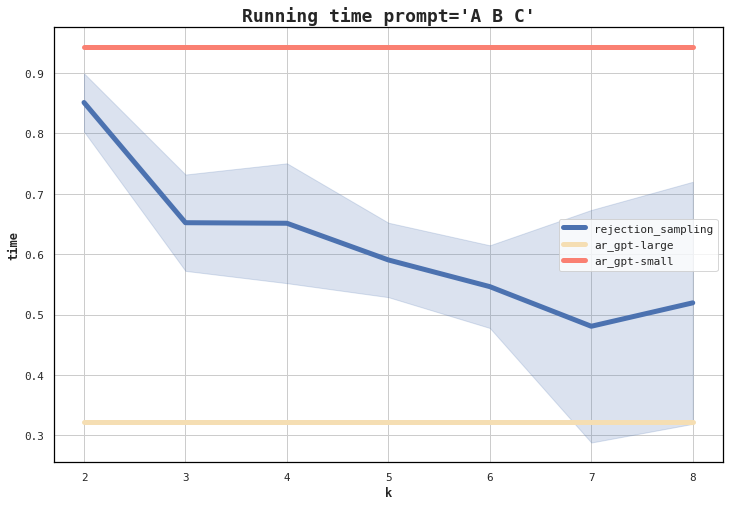

In [ ]:
prompt = "A B C"
title = f"Running time prompt='{prompt}'"

sns.lineplot(data=df[(df["prompt"] == "A B C") & (df["algorithm"] == "rejection_sampling")], x="k", y="time", ci="sd", label="rejection_sampling")

sns.lineplot(y=df[(df["prompt"] == "A B C") & (df["model"] == "gpt2")]["time"].mean(), 
             x=df[(df["prompt"] == "A B C") & (df["algorithm"] == "rejection_sampling")]["k"], label="ar_gpt-large", color="wheat")

sns.lineplot(y=df[(df["prompt"] == "A B C") & (df["model"] == "gpt2-large")]["time"].mean(), 
             x=df[(df["prompt"] == "A B C") & (df["algorithm"] == "rejection_sampling")]["k"], label="ar_gpt-small", color="salmon").set_title(title)

*speed up by prompt*

The mean running time of a prompt-k pairs. Great improvement for the easy prompt. Hard prompt and large k tend to be slow. 

In [ ]:
pd.pivot_table(data=df, columns = ["algorithm", "model","k"], index="prompt", values= "time", aggfunc="mean")

algorithm                                          autoregressive             \
model                                                        gpt2 gpt2-large   
k                                                               0          0   
prompt                                                                         
100, 99, 98, 97                                              0.33       0.95   
A B C                                                        0.32       0.94   
It was the best of times, it was the worst of t...           0.32       0.94   
The Rolling Stones first album is                            0.33       0.95   
What is the maximum entropy probability density...           0.33       0.95   
what are you thinking about?                                 0.32       0.94   

algorithm                                          rejection_sampling        \
model                                                               -         
k                                                                   2     3   
prompt                                                                        
100, 99, 98, 97                                                  0.87  0.75   
A B C                                                            0.85  0.65   
It was the best of times, it was the worst of t...               1.01  1.02   
The Rolling Stones first album is                                0.98  0.91   
What is the maximum entropy probability density...               0.94  0.90   
what are you thinking about?                                     0.94  0.85   

algorithm                                                                   \
model                                                                        
k                                                      4     5     6     7   
prompt                                                                       
100, 99, 98, 97                                     0.73  0.74  0.74  0.72   
A B C                                               0.65  0.59  0.55  0.48   
It was the best of times, it was the worst of t...  1.14  1.20  1.29  1.41   
The Rolling Stones first album is                   0.86  0.93  0.95  1.09   
What is the maximum entropy probability density...  0.86  0.91  0.92  1.11   
what are you thinking about?                        0.86  0.90  0.90  1.02   

algorithm                                                 
model                                                     
k                                                      8  
prompt                                                    
100, 99, 98, 97                                     0.73  
A B C                                               0.52  
It was the best of times, it was the worst of t...  1.52  
The Rolling Stones first album is                   1.07  
What is the maximum entropy probability density...  1.12  
what are you thinking about?                        1.00

average percent speed up for k=3, n=21:

In [ ]:
tmp = pd.pivot_table(data=df[
    (df["k"] == 3) | (df["k"] == 0)
    ], columns = ["algorithm", "model","k"], index="prompt", values= "time", aggfunc="mean")
tmp.columns = ["small","big","rejection_sampling"]
tmp["rejection_sampling"] /= tmp["big"]/100
tmp[["rejection_sampling"]]

,rejection_sampling
prompt,
"100, 99, 98, 97",78.83
A B C,69.18
"It was the best of times, it was the worst of times, it was",108.46
The Rolling Stones first album is,95.87
What is the maximum entropy probability density function for a continuous variable of given mean and standard deviation?,94.65
what are you thinking about?,90.22


In [3]:
# export to html

#!jupyter nbconvert --to html speculative_sampling.ipynb

SyntaxError: ignored